## getting the dataset

In [192]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [246]:
import pandas as pd
NEO_original = pd.read_excel("/content/drive/MyDrive/neo/NeoPIRCompleteTable_+_Other_features_of_applicants_+_second_interview.xlsx")
job_categories = pd.read_excel(r"/content/drive/MyDrive/neo/Job-Categories-Services.xlsx")
NEO = NEO_original.merge(job_categories[["Category", "job"]], left_on='title', right_on='job', how='left')
NEO = NEO[NEO['Category'] == 'Services']
NEO

,job_applicant_id,user_id,job_id,title,organization_id,total_education_years,last_degree,is_non_private_university,age_group,gender,contract_type,step_type,final_target,sum_of_experience_years,response,Category,job
500,3101,5111,562,کارمند دفتر فنی,337,NaN,NaN,NaN,NaN,NaN,1,NaN,0,NaN,"{""625"":0,""626"":4,""635"":1,""636"":4,""637"":4,""638""...",Services,کارمند دفتر فنی
646,4417,174492,562,کارمند دفتر فنی,337,4.6687,3.0,1.0,NaN,0.0,1,NaN,0,NaN,"{""625"":1,""626"":3,""627"":4,""628"":2,""629"":3,""630""...",Services,کارمند دفتر فنی
860,6356,226175,834,صندوقدار و پرزنت کننده غذا,1092,NaN,NaN,NaN,NaN,0.0,0,1.0,0,NaN,"{""625"":1,""626"":3,""627"":4,""628"":1,""629"":3,""630""...",Services,صندوقدار و پرزنت کننده غذا
862,6363,226530,834,صندوقدار و پرزنت کننده غذا,1092,NaN,NaN,NaN,NaN,0.0,0,1.0,0,NaN,"{""625"":1,""626"":3,""627"":4,""628"":2,""629"":3,""630""...",Services,صندوقدار و پرزنت کننده غذا
863,6366,226569,834,صندوقدار و پرزنت کننده غذا,1092,7.4973,3.0,0.0,NaN,0.0,0,9.0,0,NaN,"{""625"":3,""626"":1,""627"":3,""628"":1,""629"":4,""630""...",Services,صندوقدار و پرزنت کننده غذا
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14220,384507,25348412,6779,خبرنگار صنعت معدن,2952,NaN,3.0,NaN,NaN,NaN,1,4.0,2,NaN,"{""625"":2,""626"":3,""627"":3,""628"":1,""629"":3,""630""...",Services,خبرنگار صنعت معدن
14296,388488,2155789,6978,پرسنل اداری,3522,NaN,NaN,NaN,NaN,NaN,1,1.0,0,NaN,"{""625"":3,""626"":4,""627"":3,""628"":0,""629"":4,""630""...",Services,پرسنل اداری
14310,389151,25351089,6978,پرسنل اداری,3522,NaN,NaN,NaN,NaN,NaN,1,1.0,0,NaN,"{""625"":4,""626"":0,""627"":4,""628"":1,""629"":3,""630""...",Services,پرسنل اداری
14312,389174,25351102,6978,پرسنل اداری,3522,NaN,NaN,NaN,NaN,NaN,1,1.0,0,NaN,"{""625"":1,""626"":3,""627"":4,""628"":1,""629"":1,""630""...",Services,پرسنل اداری


In [194]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [195]:
NEO.drop(columns=['job'], inplace=True)
NEO.drop(columns=['Category'], inplace=True)

## mapping resoponses out and create personality labels from them

### extracting the json Responses

#### marking a score binery for each of the 240 questions and **getting average** to calculate the 30 factors

In [247]:
NEO = pd.DataFrame(NEO)
import pandas as pd
import json

df_applicants = NEO
df_mapping = pd.read_excel("/content/drive/MyDrive/neo/mapping_data.xlsx")

def parse_json_safe(answer):
    if isinstance(answer, str):
        return json.loads(answer)
    else:
        return {}

df_applicants['answers_dict'] = df_applicants['response'].apply(parse_json_safe)

# Question_id as index in the mapping DataFrame for faster lookups
df_mapping = df_mapping.set_index('question_id')

# Define the function to aggregate answers by factor with binary scaling
def aggregate_by_factor(answers_dict, mapping_df):
    factor_scores = {}

    for question_id_str, answer_value in answers_dict.items():
        question_id = int(question_id_str)

        if question_id in mapping_df.index:
            factor_id = mapping_df.loc[question_id, 'factor_id']

            # Scale the response to binary class (0 or 1)
            binary_value = 1 if answer_value >= 2.5 else 0

            # Aggregate the binary score for each factor                                                #########question #########
            if factor_id not in factor_scores:
                factor_scores[factor_id] = []
            factor_scores[factor_id].append(binary_value)

    # Average the binary scores for each factor
    factor_averages = {factor: sum(scores) / len(scores) for factor, scores in factor_scores.items()}   ######## average each factor using mapping data to figure out factors ###
                                                                                                        ######## score ???  ########
    return factor_averages

#  Apply the aggregation function to each applicant's answers
df_applicants['factor_scores'] = df_applicants['answers_dict'].apply(aggregate_by_factor, mapping_df=df_mapping)

#  Convert the factor scores dictionary into individual columns
df_factors = df_applicants['factor_scores'].apply(pd.Series)

# Combine the applicant data with the factor scores
df_final_avg = pd.concat([df_applicants.drop(columns=['response', 'answers_dict', 'factor_scores']), df_factors], axis=1)

# Output the final result to a new Excel file
df_final_avg.to_excel(r"C:\Users\ASUS\Desktop\applicant_factors.xlsx", index=False)
## print("Data has been processed, duplicates removed, and saved to 'applicant_factors.xlsx'.")
df_final_avg

,job_applicant_id,user_id,job_id,title,organization_id,total_education_years,last_degree,is_non_private_university,age_group,gender,...,73,79,68,74,51,57,63,69,75,52
500,3101,5111,562,کارمند دفتر فنی,337,NaN,NaN,NaN,NaN,NaN,...,0.625,0.750,0.625,0.500,0.428571,0.250,0.125,0.750,1.000,0.285714
646,4417,174492,562,کارمند دفتر فنی,337,4.6687,3.0,1.0,NaN,0.0,...,0.125,0.500,0.500,0.625,0.142857,0.375,0.375,0.250,0.375,0.285714
860,6356,226175,834,صندوقدار و پرزنت کننده غذا,1092,NaN,NaN,NaN,NaN,0.0,...,0.625,0.625,0.625,0.750,0.571429,0.750,0.500,0.875,0.250,0.571429
862,6363,226530,834,صندوقدار و پرزنت کننده غذا,1092,NaN,NaN,NaN,NaN,0.0,...,0.500,0.500,0.375,0.625,0.428571,0.375,0.375,0.500,0.375,0.000000
863,6366,226569,834,صندوقدار و پرزنت کننده غذا,1092,7.4973,3.0,0.0,NaN,0.0,...,0.750,0.625,0.625,0.500,0.285714,0.375,0.375,0.500,0.375,0.142857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14220,384507,25348412,6779,خبرنگار صنعت معدن,2952,NaN,3.0,NaN,NaN,NaN,...,0.625,0.625,0.500,0.250,0.285714,0.250,0.500,0.250,0.375,0.142857
14296,388488,2155789,6978,پرسنل اداری,3522,NaN,NaN,NaN,NaN,NaN,...,0.375,1.000,0.375,0.625,0.285714,0.375,0.500,0.500,0.375,0.285714
14310,389151,25351089,6978,پرسنل اداری,3522,NaN,NaN,NaN,NaN,NaN,...,0.750,0.750,0.750,0.625,0.428571,0.500,0.875,0.750,0.250,0.428571
14312,389174,25351102,6978,پرسنل اداری,3522,NaN,NaN,NaN,NaN,NaN,...,0.625,0.625,0.375,0.375,0.571429,0.125,0.500,0.375,0.250,0.428571


### marking a score binery for each of the 240 questions and  **majority voting method** to calculate the 30 factors

In [248]:
# Here is the same code as above but with the VOTING logic applied instead of average
## getting the resoponses out and create personality labels from them
source_df = NEO
import pandas as pd
import json

# Step 1: Load Excel files
df_applicants = source_df
df_mapping = pd.read_excel(r"/content/drive/MyDrive/neo/mapping_data.xlsx")  # adjust with the correct file path

# Step 2: Drop duplicate applicant_id rows, keeping the first occurrence
# ## drop applicants whose jobs are not available (for note: these are not real applicants but accounts built for test)
df_applicants = df_applicants.drop_duplicates(subset='job_applicant_id', keep='first') ### duplicate o chejurii begirim yedoone sotoon applicant_id darim
# df_applicants = df_applicants.dropna(subset='Category')

# Step 3: Parse the answers column (convert JSON string to dictionary)
# Handle missing or invalid data (NaN or non-string)
def parse_json_safe(answer):
    if isinstance(answer, str):
        return json.loads(answer)
    else:
        return {}  # Return an empty dictionary for invalid or missing answers

df_applicants['answers_dict'] = df_applicants['response'].apply(parse_json_safe)

# Step 4: Set question_id as index in the mapping DataFrame for faster lookups
df_mapping = df_mapping.set_index('question_id')

# Step 5: Define the function to apply voting logic for aggregation
def aggregate_by_voting(answers_dict, mapping_df):
    factor_scores = {}

    for question_id_str, answer_value in answers_dict.items():
        question_id = int(question_id_str)

        if question_id in mapping_df.index:
            factor_id = mapping_df.loc[question_id, 'factor_id']

            # Scale the response to binary class (0 or 1)
            binary_value = 1 if answer_value >= 2.5 else 0

            # Aggregate the binary score for each factor
            if factor_id not in factor_scores:
                factor_scores[factor_id] = []
            factor_scores[factor_id].append(binary_value)

    # Apply voting logic for each factor
    factor_votes = {}
    for factor, scores in factor_scores.items():
        count_0 = scores.count(0)
        count_1 = scores.count(1)

        ##### Majority voting logic #####
        if count_1 > count_0:
            factor_votes[factor] = 1
        elif count_0 > count_1:
            factor_votes[factor] = 0
        else:
            factor_votes[factor] = 0.5  # If there is no majority, assign 0.5

    return factor_votes

# Step 6: Apply the aggregation function to each applicant's answers
df_applicants['factor_scores'] = df_applicants['answers_dict'].apply(aggregate_by_voting, mapping_df=df_mapping)

# Step 7: Convert the factor scores dictionary into individual columns
df_factors = df_applicants['factor_scores'].apply(pd.Series)

# Step 8: Combine the applicant data with the factor scores
df_final_voting = pd.concat([df_applicants.drop(columns=['response', 'answers_dict', 'factor_scores']), df_factors], axis=1)

# Step 9: Output the final result to a new Excel file
df_final_voting.to_excel(r"C:\Users\ASUS\Desktop\applicant_factors_voting.xlsx", index=False)
## print("Data has been processed, duplicates removed, and saved to 'applicant_factors_voting.xlsx'.")
# df_final

In [244]:
df_final_voting

,job_applicant_id,user_id,job_id,title,organization_id,total_education_years,last_degree,is_non_private_university,age_group,gender,...,73,79,68,74,51,57,63,69,75,52
500,3101,5111,562,کارمند دفتر فنی,337,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,0.5,0.0,0.0,0.0,1.0,1.0,0.0
646,4417,174492,562,کارمند دفتر فنی,337,4.6687,3.0,1.0,NaN,0.0,...,0.0,0.5,0.5,1.0,0.0,0.0,0.0,0.0,0.0,0.0
860,6356,226175,834,صندوقدار و پرزنت کننده غذا,1092,NaN,NaN,NaN,NaN,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.5,1.0,0.0,1.0
862,6363,226530,834,صندوقدار و پرزنت کننده غذا,1092,NaN,NaN,NaN,NaN,0.0,...,0.5,0.5,0.0,1.0,0.0,0.0,0.0,0.5,0.0,0.0
863,6366,226569,834,صندوقدار و پرزنت کننده غذا,1092,7.4973,3.0,0.0,NaN,0.0,...,1.0,1.0,1.0,0.5,0.0,0.0,0.0,0.5,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14220,384507,25348412,6779,خبرنگار صنعت معدن,2952,NaN,3.0,NaN,NaN,NaN,...,1.0,1.0,0.5,0.0,0.0,0.0,0.5,0.0,0.0,0.0
14296,388488,2155789,6978,پرسنل اداری,3522,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,0.0,1.0,0.0,0.0,0.5,0.5,0.0,0.0
14310,389151,25351089,6978,پرسنل اداری,3522,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,0.0,0.5,1.0,1.0,0.0,0.0
14312,389174,25351102,6978,پرسنل اداری,3522,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,0.0,0.0,1.0,0.0,0.5,0.0,0.0,0.0


### another version of calculating the 30 factor by calculates the average for the 8 question of each factor the factor and if the average is above threshold 2 returns 1 else 0

In [249]:

import pandas as pd
import json

source_df = NEO
df_applicants = source_df
df_mapping = pd.read_excel("/content/drive/MyDrive/neo/mapping_data.xlsx")  # adjust with the correct file path

# Step 2: Drop duplicate applicant_id rows, keeping the first occurrence
## drop applicants whose jobs are not available (for note: these are not real applicants but accounts built for test)
df_applicants = df_applicants.drop_duplicates(subset='job_applicant_id', keep='first')

# Step 3: Parse the answers column (convert JSON string to dictionary)
# Handle missing or invalid data (NaN or non-string)
def parse_json_safe(answer):
    if isinstance(answer, str):
        return json.loads(answer)
    else:
        return {}

df_applicants['answers_dict'] = df_applicants['response'].apply(parse_json_safe)

# Step 4: Set question_id as index in the mapping DataFrame for faster lookups
df_mapping = df_mapping.set_index('question_id')

# Step 5: Define the function to apply average-based aggregation logic
def aggregate_by_average(answers_dict, mapping_df, threshold=2.0):              #############  derfan average???? chara 2??? ###########################
    factor_scores = {}

    for question_id_str, answer_value in answers_dict.items():
        question_id = int(question_id_str)

        if question_id in mapping_df.index:
            factor_id = mapping_df.loc[question_id, 'factor_id']

            # Group responses by their corresponding factor
            if factor_id not in factor_scores:
                factor_scores[factor_id] = []
            factor_scores[factor_id].append(answer_value)

    # Calculate average for each factor and apply threshold
    factor_average_scores = {}
    for factor, scores in factor_scores.items():
        avg_score = sum(scores) / len(scores)  # Compute the average
        factor_average_scores[factor] = 1 if avg_score >= threshold else 0  # Apply threshold logic

    return factor_average_scores

# Step 6: Apply the aggregation function to each applicant's answers
df_applicants['factor_scores'] = df_applicants['answers_dict'].apply(
    aggregate_by_average, mapping_df=df_mapping, threshold=2.0
)

# Step 7: Convert the factor scores dictionary into individual columns
df_factors = df_applicants['factor_scores'].apply(pd.Series)

# Step 8: Combine the applicant data with the factor scores
df_final_average = pd.concat([df_applicants.drop(columns=['response', 'answers_dict', 'factor_scores']), df_factors], axis=1)

# Step 9: Output the final result to a new Excel file
## df_final_average.to_excel(r"C:\Users\MJavad\Desktop\applicant_factors_average.xlsx", index=False)
## print("Data has been processed, duplicates removed, and saved to 'applicant_factors_average.xlsx'.")
# df_final
NEO = df_final_average
NEO.head()

,job_applicant_id,user_id,job_id,title,organization_id,total_education_years,last_degree,is_non_private_university,age_group,gender,...,73,79,68,74,51,57,63,69,75,52
500,3101,5111,562,کارمند دفتر فنی,337,NaN,NaN,NaN,NaN,NaN,...,1,1,1,1,0,0,0,1,1,0
646,4417,174492,562,کارمند دفتر فنی,337,4.6687,3.0,1.0,NaN,0.0,...,1,1,1,1,0,0,0,0,1,1
860,6356,226175,834,صندوقدار و پرزنت کننده غذا,1092,NaN,NaN,NaN,NaN,0.0,...,1,1,1,1,1,1,1,1,0,1
862,6363,226530,834,صندوقدار و پرزنت کننده غذا,1092,NaN,NaN,NaN,NaN,0.0,...,1,1,1,1,1,0,0,1,1,0
863,6366,226569,834,صندوقدار و پرزنت کننده غذا,1092,7.4973,3.0,0.0,NaN,0.0,...,1,1,1,1,0,0,1,1,1,0


## mapping the responses of the factors to the 5 major traits (by calsulating the mean of the answers) using the answers of the voting method

In [200]:
# this is the default code to calculate trait
df_5_traits = df_final_voting                                      ############## where was the comparison???  ##########
group_mapping = {
    'Neuroticism': [50, 51, 52, 53, 54, 55],
    'Extraversion': [56, 57, 58, 59, 60, 61],
    'Openness to experience': [62, 63, 64, 65, 66, 67],
    'Agreeableness': [68, 69, 70, 71, 72, 73],
    'Conscientiousness': [74, 75, 76, 77, 78, 79]
}

# Function to calculate the average score for each trait
def calculate_large_group_scores(df_5_traits, group_mapping):
    large_group_scores = {}
    for group_name, factors in group_mapping.items():
        # Select the columns corresponding to the factors
        factor_columns = [int(factor) for factor in factors if int(factor) in df_5_traits.columns]

        # Calculate the average score for the group, ignoring missing values
        df_5_traits[group_name] = df_5_traits[factor_columns].mean(axis=1)

    return df_5_traits

# Apply the function to calculate large group scores
df_large_groups = calculate_large_group_scores(df_5_traits.copy(), group_mapping)
#df_large_groups
# Select only the necessary columns for the final DataFrame
NEO_with_traits = df_large_groups[['job_applicant_id'] + list(group_mapping.keys()) + ['final_target']]                   ##########    fargh  user_id   and id  ???? #############

pd.DataFrame(NEO_with_traits.describe())

,user_id,Neuroticism,Extraversion,Openness to experience,Agreeableness,Conscientiousness,final_target
count,6.050000e+02,605.000000,605.000000,605.000000,605.000000,605.000000,605.000000
mean,7.707373e+06,0.319146,0.485399,0.448347,0.509091,0.681405,0.084298
std,1.050815e+07,0.207628,0.239799,0.232672,0.235819,0.202657,0.295386
min,2.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.491440e+05,0.166667,0.333333,0.250000,0.333333,0.583333,0.000000
50%,2.008016e+06,0.333333,0.500000,0.416667,0.500000,0.750000,0.000000
75%,2.423823e+07,0.416667,0.666667,0.583333,0.666667,0.833333,0.000000
max,2.535110e+07,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000


In [201]:
NEO_with_traits['final_target'].value_counts()

,count
final_target,
0,557
1,45
2,3


In [202]:
df_final_voting.groupby(['final_target'])['user_id'].count()

,user_id
final_target,
0,557
1,45
2,3


## missing values

In [203]:
## to see how many nulls columns have
pd.DataFrame(NEO.isna().mean().sort_values(ascending=False).loc[lambda x: x > 0.01])                         ########### missing value kheylie k !!!!!!!! #############

,0
is_non_private_university,0.849794
sum_of_experience_years,0.744856
total_education_years,0.592593
age_group,0.567901
last_degree,0.534979
gender,0.522634
step_type,0.141975


In [204]:
NEO.isna().mean().sort_values(ascending=False)


,0
is_non_private_university,0.849794
sum_of_experience_years,0.744856
total_education_years,0.592593
age_group,0.567901
last_degree,0.534979
gender,0.522634
step_type,0.141975
job_applicant_id,0.000000
79,0.000000
66,0.000000


In [205]:
NEO.info()

<class 'pandas.core.frame.DataFrame'>
Index: 486 entries, 500 to 14313
Data columns (total 44 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   job_applicant_id           486 non-null    int64  
 1   user_id                    486 non-null    int64  
 2   job_id                     486 non-null    int64  
 3   title                      486 non-null    object 
 4   organization_id            486 non-null    int64  
 5   total_education_years      198 non-null    float64
 6   last_degree                226 non-null    float64
 7   is_non_private_university  73 non-null     float64
 8   age_group                  210 non-null    float64
 9   gender                     232 non-null    float64
 10  contract_type              486 non-null    int64  
 11  step_type                  417 non-null    float64
 12  final_target               486 non-null    int64  
 13  sum_of_experience_years    124 non-null    float64


In [206]:
NEO_with_traits.info()

<class 'pandas.core.frame.DataFrame'>
Index: 605 entries, 500 to 14313
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   user_id                 605 non-null    int64  
 1   Neuroticism             605 non-null    float64
 2   Extraversion            605 non-null    float64
 3   Openness to experience  605 non-null    float64
 4   Agreeableness           605 non-null    float64
 5   Conscientiousness       605 non-null    float64
 6   final_target            605 non-null    int64  
dtypes: float64(5), int64(2)
memory usage: 37.8 KB


## defining datasets with deferent final targets 0 and 1-2    


DARAM AZ

In [250]:
df_with_all = NEO_with_traits.merge(NEO[["job_applicant_id","job_id","total_education_years","last_degree","age_group","gender","sum_of_experience_years","is_non_private_university","contract_type","step_type"]],on='user_id', how='inner')
df_with_all

KeyError: 'user_id'

In [208]:
df_target_0 = df_with_all[df_with_all['final_target']==0]
df_target_0.info()


<class 'pandas.core.frame.DataFrame'>
Index: 557 entries, 0 to 604
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   user_id                    557 non-null    int64  
 1   Neuroticism                557 non-null    float64
 2   Extraversion               557 non-null    float64
 3   Openness to experience     557 non-null    float64
 4   Agreeableness              557 non-null    float64
 5   Conscientiousness          557 non-null    float64
 6   final_target               557 non-null    int64  
 7   job_id                     557 non-null    int64  
 8   total_education_years      242 non-null    float64
 9   last_degree                270 non-null    float64
 10  age_group                  241 non-null    float64
 11  gender                     285 non-null    float64
 12  sum_of_experience_years    162 non-null    float64
 13  is_non_private_university  89 non-null     float64
 14 

In [209]:
df_target_1_2 = df_with_all[df_with_all['final_target'].isin((1,2))]
df_target_1_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48 entries, 23 to 600
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   user_id                    48 non-null     int64  
 1   Neuroticism                48 non-null     float64
 2   Extraversion               48 non-null     float64
 3   Openness to experience     48 non-null     float64
 4   Agreeableness              48 non-null     float64
 5   Conscientiousness          48 non-null     float64
 6   final_target               48 non-null     int64  
 7   job_id                     48 non-null     int64  
 8   total_education_years      20 non-null     float64
 9   last_degree                25 non-null     float64
 10  age_group                  17 non-null     float64
 11  gender                     18 non-null     float64
 12  sum_of_experience_years    16 non-null     float64
 13  is_non_private_university  5 non-null      float64
 14 

## Plots

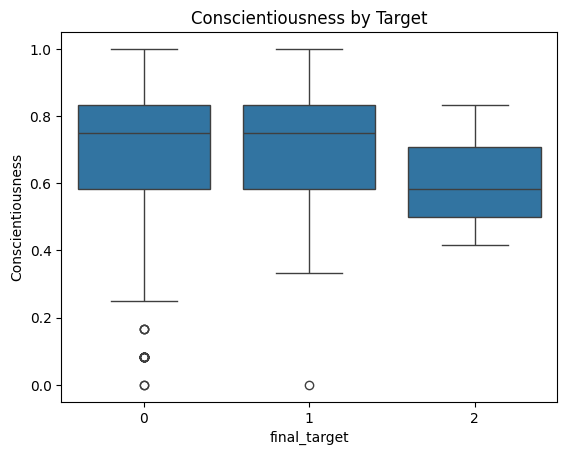

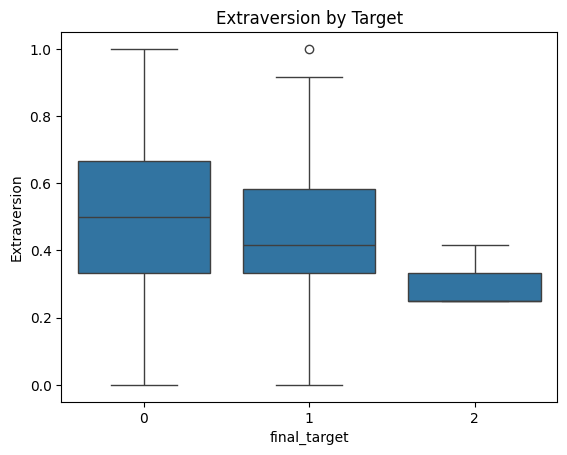

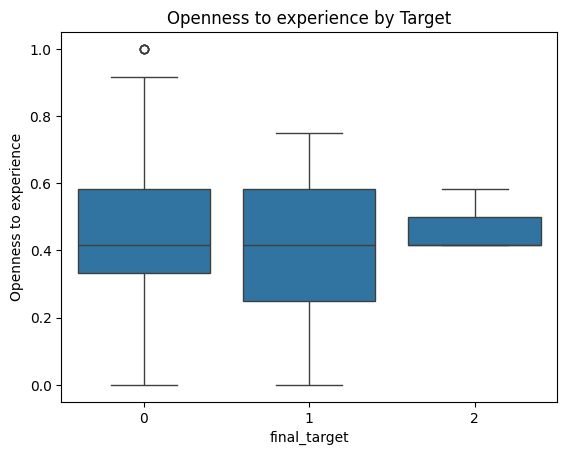

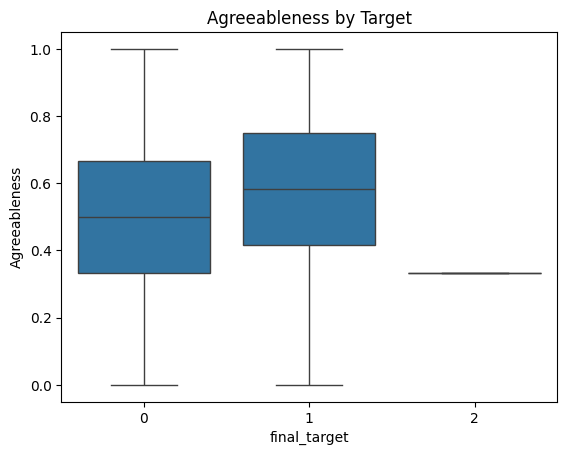

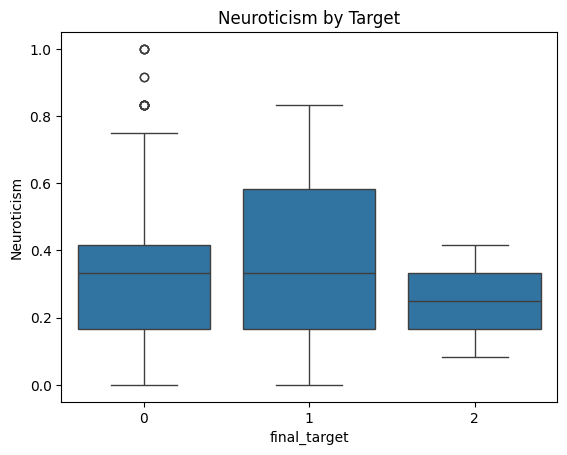

In [210]:
# Box plot with respect to target
# 'Neuroticism', 'Extraversion', 'Openness to experience', 'Agreeableness', 'Conscientiousness'
import matplotlib.pyplot as plt
import seaborn as sns

sns.boxplot(x='final_target', y='Conscientiousness', data=NEO_with_traits)
plt.title('Conscientiousness by Target')
plt.show()

sns.boxplot(x='final_target', y='Extraversion', data=NEO_with_traits)
plt.title('Extraversion by Target')
plt.show()

sns.boxplot(x='final_target', y='Openness to experience', data=NEO_with_traits)
plt.title('Openness to experience by Target')
plt.show()

sns.boxplot(x='final_target', y='Agreeableness', data=NEO_with_traits)
plt.title('Agreeableness by Target')
plt.show()

sns.boxplot(x='final_target', y='Neuroticism', data=NEO_with_traits)
plt.title('Neuroticism by Target')
plt.show()

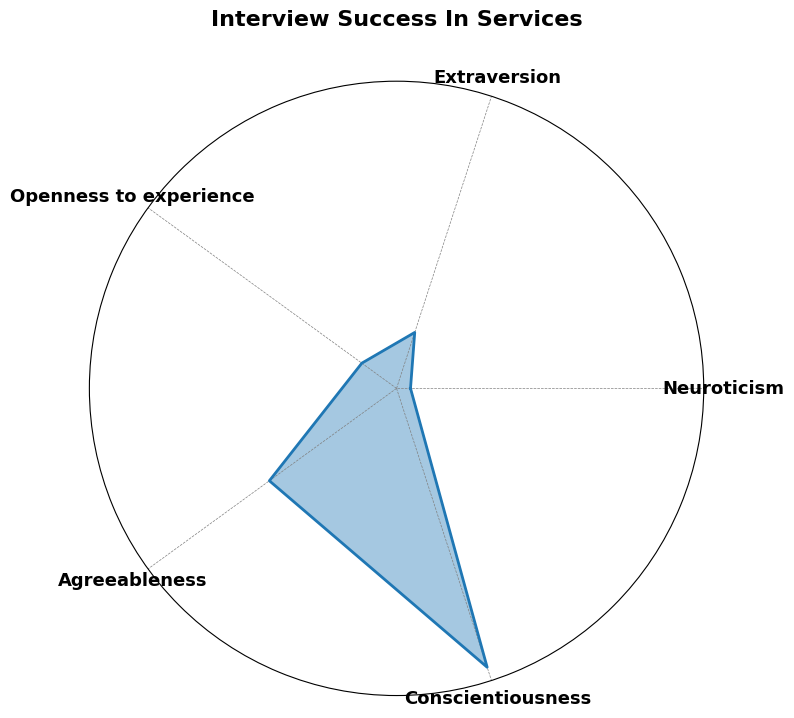

In [211]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = NEO_with_traits
# Assuming df is the DataFrame with your table structure
# Filter data by `final_target`
# df_target_1_2 = df[df['final_target'] == 2]
# df_target_0 = df[df['final_target'].isin([0, 1])]

# Calculate the average trait scores for each group
traits = ['Neuroticism', 'Extraversion', 'Openness to experience', 'Agreeableness', 'Conscientiousness']
avg_target_1_2 = df_target_1_2[traits].mean()
avg_target_0 = df_target_0[traits].mean()

# Radar chart setup
categories = traits
num_vars = len(categories)

# Compute angle for each category
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Complete the circle

# Extend the values to close the radar chart
avg_target_1_2 = avg_target_1_2.tolist() + avg_target_1_2.tolist()[:1]
avg_target_0 = avg_target_0.tolist() + avg_target_0.tolist()[:1]

# Create the radar chart
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Plot the data with professional color scheme
ax.fill(angles, avg_target_1_2, color='#1f77b4', alpha=0.4, label='The Successful Profile')
ax.plot(angles, avg_target_1_2, color='#1f77b4', linewidth=2)

# ax.fill(angles, avg_target_1_0, color='#d62728', alpha=0.4, label='Target 1 and 0')
# ax.plot(angles, avg_target_1_0, color='#d62728', linewidth=2)

# Add category labels
ax.set_yticks([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=13, fontweight='bold', color='black')

# Add gridlines
ax.grid(linewidth=0.5, linestyle='--', color='gray')

# Set the title and adjust for better alignment
plt.title('Interview Success In Services', size=16, pad=40, fontweight='bold', color='black')

# Place legend outside the chart for a cleaner look
# plt.legend(loc='upper left', bbox_to_anchor=(1.15, 1), fontsize=12, title_fontsize='13')

# Show the plot with a professional background
plt.tight_layout()  # Ensures the chart fits within the layout
plt.show()

###This code generates random data for a single individual's Big Five personality traits, assigns them a random category (final target), and visualizes the average trait scores across different groups using a radar chart.
"Target 1 and 2" (blue shaded area)
"Target 0" (red shaded area)

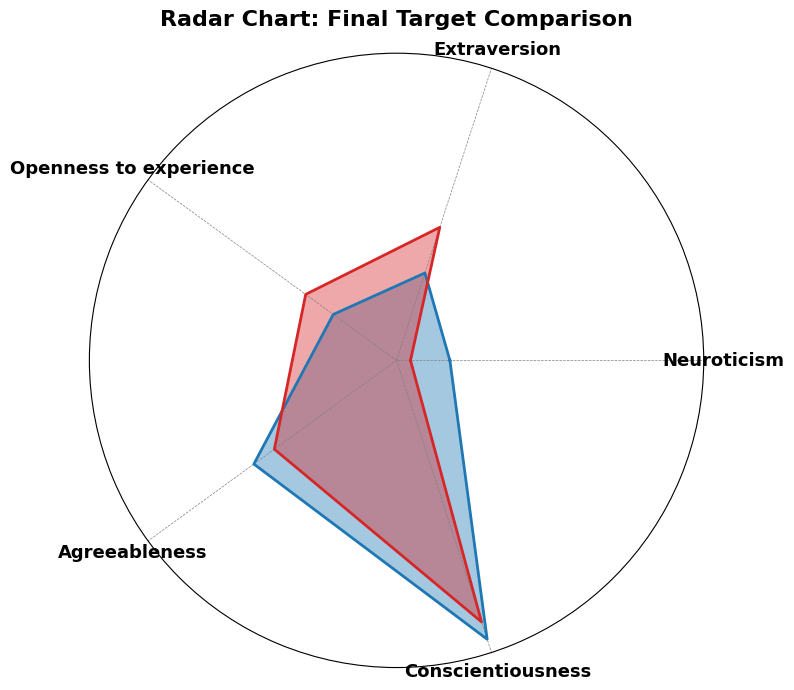

,Neuroticism,Extraversion,Openness to experience,Agreeableness,Conscientiousness,final_target
0,0.37454,0.950714,0.731994,0.598658,0.156019,2


In [212]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Generate a random sample of one person
np.random.seed(42)  # For reproducibility

# Random scores for Big Five personality traits (values between 0 and 1)
neuroticism = np.random.rand()
extraversion = np.random.rand()
openness = np.random.rand()
agreeableness = np.random.rand()
conscientiousness = np.random.rand()

# Assign a random final target (0, 1, or 2)
final_target = np.random.choice([0, 1, 2])

# Create a DataFrame with this person's data
data = {
    'Neuroticism': [neuroticism],
    'Extraversion': [extraversion],
    'Openness to experience': [openness],
    'Agreeableness': [agreeableness],
    'Conscientiousness': [conscientiousness],
    'final_target': [final_target]
}

df = pd.DataFrame(data)

# Filter data by final_target
# df_target_1 = df[df['final_target'] == 1]
# df_target_0 = df[df['final_target']== 0 ]

# Calculate the average trait scores for each group
traits = ['Neuroticism', 'Extraversion', 'Openness to experience', 'Agreeableness', 'Conscientiousness']
avg_target_1_2 = df_target_1_2[traits].mean()
avg_target_0 = df_target_0[traits].mean()

# Radar chart setup
categories = traits
num_vars = len(categories)

# Compute angle for each category
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Complete the circle

# Extend the values to close the radar chart
avg_target_1_2 = avg_target_1_2.tolist() + avg_target_1_2.tolist()[:1]
avg_target_0 = avg_target_0.tolist() + avg_target_0.tolist()[:1]

# Create the radar chart
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Plot the data with professional color scheme
ax.fill(angles, avg_target_1_2, color='#1f77b4', alpha=0.4, label='Target 2')
ax.plot(angles, avg_target_1_2, color='#1f77b4', linewidth=2)

ax.fill(angles, avg_target_0, color='#d62728', alpha=0.4, label='Target 1 and 0')
ax.plot(angles, avg_target_0, color='#d62728', linewidth=2)

# Add category labels
ax.set_yticks([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=13, fontweight='bold', color='black')

# Add gridlines
ax.grid(linewidth=0.5, linestyle='--', color='gray')

# Set the title and adjust for better alignment
plt.title('Radar Chart: Final Target Comparison', size=16, pad=20, fontweight='bold', color='black')

# Place legend outside the chart for a cleaner look
## plt.legend(loc='upper left', bbox_to_anchor=(1.15, 1), fontsize=12, title="Final Target", title_fontsize='13')

# Show the plot with a professional background
plt.tight_layout()  # Ensures the chart fits within the layout
plt.show()
pd.DataFrame(df)

### new comparison plot

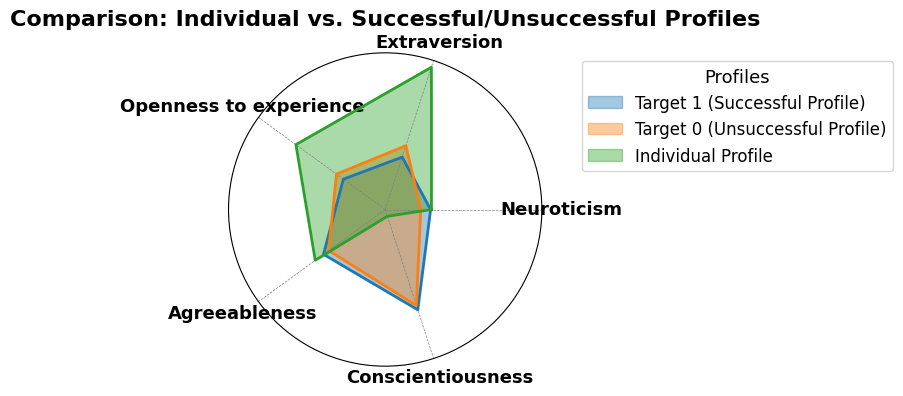

In [213]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Example DataFrames: Replace these with your actual DataFrames
df = NEO_with_traits

# Generate a random sample for one individual
np.random.seed(42)
individual_data = {
    'Neuroticism': [np.random.rand()],
    'Extraversion': [np.random.rand()],
    'Openness to experience': [np.random.rand()],
    'Agreeableness': [np.random.rand()],
    'Conscientiousness': [np.random.rand()],
    'final_target': [np.random.choice([0, 1])]  # Fixed random target choice between 0 and 1
}
df_individual = pd.DataFrame(individual_data)

# Filter data for group averages
# df_target_1 = df[df['final_target'] == 1]
# df_target_0 = df[df['final_target'] == 0]

# Calculate the average trait scores for each group
traits = ['Neuroticism', 'Extraversion', 'Openness to experience', 'Agreeableness', 'Conscientiousness']
avg_target_1_2 = df_target_1_2[traits].mean()
avg_target_0 = df_target_0[traits].mean()

# Extract individual's trait scores
individual_scores = df_individual[traits].iloc[0]

# Radar chart setup
categories = traits
num_vars = len(categories)

# Compute angle for each category
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Complete the circle

# Extend the values to close the radar chart
avg_target_1_2 = avg_target_1_2.tolist() + avg_target_1_2.tolist()[:1]
avg_target_0 = avg_target_0.tolist() + avg_target_0.tolist()[:1]
individual_scores = individual_scores.tolist() + individual_scores.tolist()[:1]

# Create the radar chart
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Plot the data
ax.fill(angles, avg_target_1_2, color='#1f77b4', alpha=0.4, label='Target 1 (Successful Profile)')
ax.plot(angles, avg_target_1_2, color='#1f77b4', linewidth=2)

ax.fill(angles, avg_target_0, color='#ff7f0e', alpha=0.4, label='Target 0 (Unsuccessful Profile)')
ax.plot(angles, avg_target_0, color='#ff7f0e', linewidth=2)

ax.fill(angles, individual_scores, color='#2ca02c', alpha=0.4, label='Individual Profile')
ax.plot(angles, individual_scores, color='#2ca02c', linewidth=2)

# Add category labels
ax.set_yticks([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=13, fontweight='bold', color='black')

# Add gridlines
ax.grid(linewidth=0.5, linestyle='--', color='gray')

# Set the title and adjust for better alignment
plt.title('Comparison: Individual vs. Successful/Unsuccessful Profiles', size=16, pad=20, fontweight='bold', color='black')

# Place legend outside the chart for a cleaner look
plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1), fontsize=12, title="Profiles", title_fontsize='13')

# Show the plot
plt.tight_layout()  # Ensures the chart fits within the layout
plt.show()


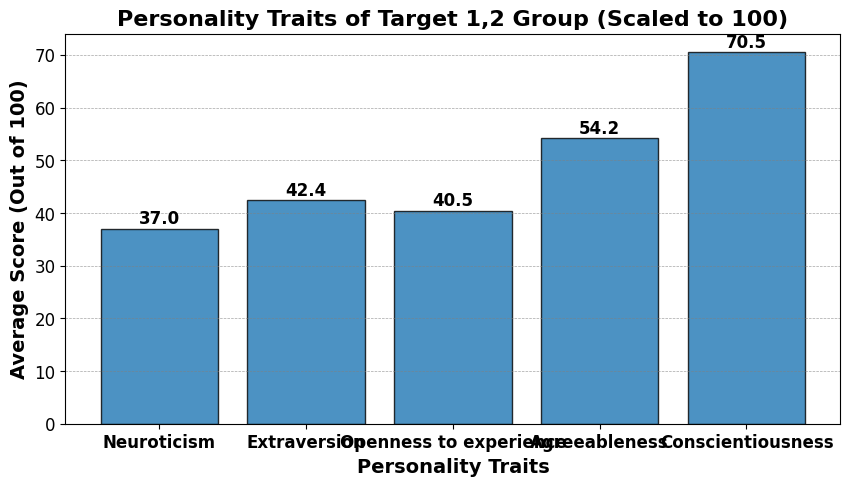

In [214]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming your dataset is named NEO_with_traits_hr and contains the required columns
# df = NEO_with_traits

# Filter data by `final_target`
# df_target_1 = df[df["final_target"] == 1]

# List of traits
traits = ["Neuroticism", "Extraversion", "Openness to experience", "Agreeableness", "Conscientiousness"]

# Calculate the average trait scores for the target 1 group and scale them to 0-100
avg_target_1_2 = df_target_1_2[traits].mean() * 100

# Create a bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(traits, avg_target_1_2, color='#1f77b4', alpha=0.8, edgecolor='black')

# Annotate the bar chart with mean values out of 100
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{height:.1f}', ha='center', fontsize=12, fontweight='bold', color='black')

# Add labels, title, and a professional look
plt.xlabel("Personality Traits", fontsize=14, fontweight="bold", color="black")
plt.ylabel("Average Score (Out of 100)", fontsize=14, fontweight="bold", color="black")
plt.title("Personality Traits of Target 1,2 Group (Scaled to 100)", fontsize=16, fontweight="bold", color="black")
plt.xticks(fontsize=12, fontweight="bold", color="black")
plt.yticks(fontsize=12, color="black")
plt.grid(axis="y", linestyle="--", linewidth=0.5, color="gray", alpha=0.7)

# Adjust margins to prevent overlap
plt.subplots_adjust(bottom=0.2, top=0.85)

# Display the plot
plt.show()

## writing the mean value of each traits in all the participants in targets 0 or 1 or 2

In [215]:
import pandas as pd

df = NEO_with_traits

# Filter data by `final_target` (only Target 2)
df_target_2 = df[df["final_target"] == 2]

# List of traits
traits = ["Neuroticism", "Extraversion", "Openness to experience", "Agreeableness", "Conscientiousness"]

# Create a new DataFrame with scores scaled to 100
df_scaled = df_target_2[traits].mean() * 100

# Display the table
print(df_scaled)

# Optional: Save the scaled table to a CSV file
df_scaled.to_excel(r"C:\Users\ASUS\Desktop\df_scaled1.xlsx")

Neuroticism               25.000000
Extraversion              30.555556
Openness to experience    47.222222
Agreeableness             33.333333
Conscientiousness         61.111111
dtype: float64


In [216]:
import pandas as pd

df = NEO_with_traits

# Filter data by `final_target` (only Target 1)
df_target_1_2 = df[df["final_target"].isin([1, 2])]

# List of traits
traits = ["Neuroticism", "Extraversion", "Openness to experience", "Agreeableness", "Conscientiousness"]

# Create a new DataFrame with scores scaled to 100
df_scaled = df_target_1_2[traits].mean() * 100

# Display the table
print(df_scaled)

# Optional: Save the scaled table to a CSV file
df_scaled.to_excel(r"C:\Users\ASUS\Desktop\df_scaled1.xlsx")

Neuroticism               36.979167
Extraversion              42.361111
Openness to experience    40.451389
Agreeableness             54.166667
Conscientiousness         70.486111
dtype: float64


Computes statistical values (mean and standard deviation) for two groups (Target 1 and Target 0).

Calculates z-scores to compare the average traits of Target 1 relative to Target 0.   ?????????????????

Outputs the z-scores to measure the difference between groups.

Computes the ratio of z-scores to the standard deviation of Target 0 for further interpretation.

In [217]:
# Calculate the standard deviation for Target 1 and 0 group                        ##########################  ???????????   ########################
std_target_0 = df_target_0[traits].std()                                           ######################### asan chera ? hamashoon tu yek vadian ##########

# Calculate the mean for Target 1 group
mean_target_1_2 = df_target_1_2[traits].mean()

# Calculate the mean for Target  0 group (used as the population mean for z-score)
mean_target_0 = df_target_0[traits].mean()

# Calculate the z-score for each trait in Target 1 group
z_scores_target_1_2 = (mean_target_1_2 - mean_target_0) / std_target_0

# Output the z-scores for Target 1 traits
print("Z-scores for Target 1 mean (relative to Target  0):")
print(z_scores_target_1_2)

# Calculate the ratio of the z-scores to the standard deviation of Target  0
ratio = z_scores_target_1_2 / std_target_0

# Output the ratio
print("Ratio of Z-scores (Target 1) to Standard Deviation (Target  0):")
print(ratio)

Z-scores for Target 1 mean (relative to Target  0):
Neuroticism               0.269397
Extraversion             -0.280753
Openness to experience   -0.204066
Agreeableness             0.150885
Conscientiousness         0.126221
dtype: float64
Ratio of Z-scores (Target 1) to Standard Deviation (Target  0):
Neuroticism               1.319295
Extraversion             -1.174474
Openness to experience   -0.874657
Agreeableness             0.643428
Conscientiousness         0.625326
dtype: float64


In [218]:
print(z_scores_target_1_2)

Neuroticism               0.269397
Extraversion             -0.280753
Openness to experience   -0.204066
Agreeableness             0.150885
Conscientiousness         0.126221
dtype: float64


## modeling NEo features using logistic regression and random forest

Prepares personality trait data and converts it into a binary classification problem.

Standardizes the features for better model performance.

Trains a **logistic regression** model with balanced class weights.

Evaluates the model using various performance metrics.

Interprets the impact of personality traits using model coefficients.

result:
The **logistic regression model** achieved an **overall accuracy of 63%**, with a **strong precision for class 0 (95%)** but poor performance for class 1, reflected in a low precision of 13% and a recall of 64%. This indicates that while the model is effective at identifying negative cases, it struggles to correctly classify positive cases, resulting in a low F1-score of 0.21 for class 1. The feature **coefficients** suggest that **Neuroticism** and **Agreeableness**??? have the most positive influence on the prediction, while Extraversion contributes negatively.

In [219]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
# NEO_with_traits['final_target'] = NEO_with_traits['final_target'].replace(1, 0)
NEO_with_traits['final_target'] = NEO_with_traits['final_target'].replace(2, 1)
# Step 1: Prepare the data (NEO traits as features, final_target as the target)
X = NEO_with_traits[['Neuroticism', 'Extraversion', 'Openness to experience', 'Agreeableness', 'Conscientiousness']]  # NEO traits
y = NEO_with_traits['final_target']  # target: job offer (0 or 1)

# Step 2: Standardize the features (NEO traits)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

# Step 4: Train Logistic Regression model with class weights to handle imbalance
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)

# Step 5: Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Coefficients to interpret the impact of NEO traits
coefficients = pd.DataFrame(model.coef_, columns=X.columns, index=['Coefficient'])
coefficients

              precision    recall  f1-score   support

           0       0.95      0.63      0.76       168
           1       0.13      0.64      0.21        14

    accuracy                           0.63       182
   macro avg       0.54      0.64      0.49       182
weighted avg       0.89      0.63      0.72       182



<ipython-input-219-45a182a1c1f3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NEO_with_traits['final_target'] = NEO_with_traits['final_target'].replace(2, 1)


,Neuroticism,Extraversion,Openness to experience,Agreeableness,Conscientiousness
Coefficient,0.671021,-0.69074,-0.365339,0.1866,0.083007


In [220]:
#  NEO_with_traits['final_target'] = NEO_with_traits['final_target'].replace(2, 1)
#  NEO_with_traits['final_target'].value_counts()

**Random Forest model**

result:

The Random Forest model shows an **overall accuracy of 63%**, but it has a significant class imbalance issue. It performs well for class 0 (negative class) with a precision of 0.95 and a recall of 0.63, yielding a decent F1-score of 0.76. However, it struggles with class 1 (positive class), with very low precision (0.13) and a high recall (0.64), leading to an F1-score of just 0.21. The macro average metrics reflect the imbalance, with a recall of 0.64 and a relatively low F1-score of 0.49, while the weighted averages indicate that the model performs much better on the majority class (class 0). The feature importance analysis suggests that **Neuroticism** is the most influential feature, followed by **Extraversion** and **Openness to experience**, while *Conscientiousness* and *Agreeableness* have less impact. The model's struggle with positive class prediction highlights the need for strategies to address class imbalance, such as re-sampling or adjusting class weights.

In [221]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd

# Step 1: Prepare the data (NEO traits as features, final_target as the target)
X = NEO_with_traits[['Neuroticism', 'Extraversion', 'Openness to experience', 'Agreeableness', 'Conscientiousness']]  # NEO traits
y = NEO_with_traits['final_target']  # target: job offer (0 or 1)

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Step 3: Train Random Forest model with class weights to handle imbalance
model = RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=100)  # Adjust hyperparameters as needed
model.fit(X_train, y_train)

# Step 4: Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Feature importances to interpret the impact of NEO traits
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importances)

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       168
           1       0.00      0.00      0.00        14

    accuracy                           0.91       182
   macro avg       0.46      0.49      0.48       182
weighted avg       0.85      0.91      0.88       182

                  Feature  Importance
4       Conscientiousness    0.227828
1            Extraversion    0.209230
0             Neuroticism    0.192469
3           Agreeableness    0.187158
2  Openness to experience    0.183314


choosing the best model:

If class imbalance is a significant issue and predicting class 1 is important (even at the cost of overall performance), **Logistic Regression** might be a better choice.

## converting log-odds to a probability

In [222]:
import numpy as np

def log_odds_to_probability(log_odds):
    return 1 / (1 + np.exp(-log_odds))

log_odds = 0.63
probability = log_odds_to_probability(log_odds)
print(f"Probability: {probability}")

Probability: 0.6524894621927444


In [223]:
from scipy.stats import pointbiserialr
import numpy as np

# Weights
class_counts = y.value_counts()
weights = np.where(y == 0, 1 / class_counts[0], 1 / class_counts[1])

# Calculate the weighted mean of X and y
weighted_mean_X = np.average(X, weights=weights, axis=0)  # Weighted mean for each trait in X
weighted_mean_y = np.average(y, weights=weights)  # Weighted mean of the target variable

# Initialize an empty list to store the weighted correlation values
weighted_correlations = []

# Calculate the weighted covariance between each trait in X and y
for i, trait in enumerate(X.columns):
    trait_values = X[trait]

    # Weighted covariance
    weighted_cov = np.sum(weights * (trait_values - weighted_mean_X[i]) * (y - weighted_mean_y)) / np.sum(weights)

    # Weighted standard deviation for the trait
    weighted_std_X = np.sqrt(np.sum(weights * (trait_values - weighted_mean_X[i])**2) / np.sum(weights))

    # Weighted standard deviation for y
    weighted_std_y = np.sqrt(np.sum(weights * (y - weighted_mean_y)**2) / np.sum(weights))

    # Weighted Point Biserial Correlation
    weighted_corr = weighted_cov / (weighted_std_X * weighted_std_y)

    # Store the result
    weighted_correlations.append(weighted_corr)

    # Print the result for each trait
    print(f"Weighted Point Biserial Correlation between {trait} and final_target: {weighted_corr:.3f}")

Weighted Point Biserial Correlation between Neuroticism and final_target: 0.123
Weighted Point Biserial Correlation between Extraversion and final_target: -0.139
Weighted Point Biserial Correlation between Openness to experience and final_target: -0.104
Weighted Point Biserial Correlation between Agreeableness and final_target: 0.073
Weighted Point Biserial Correlation between Conscientiousness and final_target: 0.062


In [224]:
null_percentage = df_with_all.isnull().sum() / len(df_with_all) * 100

null_percentage

,0
user_id,0.000000
Neuroticism,0.000000
Extraversion,0.000000
Openness to experience,0.000000
Agreeableness,0.000000
Conscientiousness,0.000000
final_target,0.000000
job_id,0.000000
total_education_years,56.694215
last_degree,51.239669


## filling the null values

In [225]:
df_with_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605 entries, 0 to 604
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   user_id                    605 non-null    int64  
 1   Neuroticism                605 non-null    float64
 2   Extraversion               605 non-null    float64
 3   Openness to experience     605 non-null    float64
 4   Agreeableness              605 non-null    float64
 5   Conscientiousness          605 non-null    float64
 6   final_target               605 non-null    int64  
 7   job_id                     605 non-null    int64  
 8   total_education_years      262 non-null    float64
 9   last_degree                295 non-null    float64
 10  age_group                  258 non-null    float64
 11  gender                     303 non-null    float64
 12  sum_of_experience_years    178 non-null    float64
 13  is_non_private_university  94 non-null     float64

In [226]:
df_with_all = df_with_all.drop(columns=['is_non_private_university'])


In [227]:
df_delete_row = df_with_all.dropna(thresh=len(df_with_all.columns) - 4)
df_delete_row.info()

<class 'pandas.core.frame.DataFrame'>
Index: 371 entries, 1 to 600
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   user_id                  371 non-null    int64  
 1   Neuroticism              371 non-null    float64
 2   Extraversion             371 non-null    float64
 3   Openness to experience   371 non-null    float64
 4   Agreeableness            371 non-null    float64
 5   Conscientiousness        371 non-null    float64
 6   final_target             371 non-null    int64  
 7   job_id                   371 non-null    int64  
 8   total_education_years    262 non-null    float64
 9   last_degree              295 non-null    float64
 10  age_group                258 non-null    float64
 11  gender                   296 non-null    float64
 12  sum_of_experience_years  178 non-null    float64
 13  contract_type            371 non-null    int64  
 14  step_type                345 no

In [228]:
# prompt: percentege of null values in df_delete_row

null_percentage = df_delete_row.isnull().sum() / len(df_delete_row) * 100
null_percentage

,0
user_id,0.000000
Neuroticism,0.000000
Extraversion,0.000000
Openness to experience,0.000000
Agreeableness,0.000000
Conscientiousness,0.000000
final_target,0.000000
job_id,0.000000
total_education_years,29.380054
last_degree,20.485175


In [229]:
## I removed all columns null values to see what remains and that equals to 152 applicants(!) out of 4773
# df_neo_null_removed = NEO.dropna()
# df_neo_null_removed.count()

## try just to remove those nulls that are exceeding 50 percent  ####################   ino man nakardam bejash row hazf kardam       ######################
# def remove_null_above_50(df, threshold=0.5):
#     null_percentage = df.isna().mean()

#     columns_to_drop = null_percentage[null_percentage > threshold].index

#     df_cleaned = df.drop(columns=columns_to_drop)

#     return df_cleaned
#df_neo_null_above_50_removed = remove_null_above_50(NEO)
### if we drop nulls after cleaning features that exceed more than 50 in null, it leads 1753 applicants with all features (uncomment to do this)
# """df_neo_null_above_50_removed = df_neo_null_above_50_removed.dropna()
# df_neo_null_above_50_removed.groupby(df_neo_null_above_50_removed['Category'])['id'].count().sort_values(ascending=False)"""
# df_neo_null_above_50_removed.isna().sum().sort_values(ascending=False)

## ino nafahmidam chi shode daghigh

In [230]:
## Dealing with other features with high number of null values

df_delete_row.groupby('last_degree')['user_id'].count().sort_values(ascending=False)
### creatign a column for treating missingness as information
### last_degree column
df_delete_row['last_degree_missing'] = df_delete_row['last_degree'].isna().astype(int)
df_delete_row['last_degree_missing']
df_delete_row['last_degree'] = df_delete_row['last_degree'].fillna(0)
df_delete_row['last_degree']

<ipython-input-230-6ccd4de4aa36>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_delete_row['last_degree_missing'] = df_delete_row['last_degree'].isna().astype(int)
<ipython-input-230-6ccd4de4aa36>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_delete_row['last_degree'] = df_delete_row['last_degree'].fillna(0)


,last_degree
1,3.0
2,0.0
3,0.0
4,3.0
7,3.0
...,...
594,4.0
595,0.0
597,6.0
598,6.0


In [231]:
df_delete_row = df_delete_row.fillna(-1)
df_delete_row

,user_id,Neuroticism,Extraversion,Openness to experience,Agreeableness,Conscientiousness,final_target,job_id,total_education_years,last_degree,age_group,gender,sum_of_experience_years,contract_type,step_type,last_degree_missing
1,174492,0.083333,0.416667,0.166667,0.083333,0.583333,0,562,4.6687,3.0,-1.0,0.0,-1.0000,1,-1.0,0
2,226175,0.666667,0.916667,0.500000,0.750000,0.750000,0,834,-1.0000,0.0,-1.0,0.0,-1.0000,0,1.0,1
3,226530,0.250000,0.500000,0.333333,0.333333,0.750000,0,834,-1.0000,0.0,-1.0,0.0,-1.0000,0,1.0,1
4,226569,0.583333,0.583333,0.666667,0.666667,0.666667,0,834,7.4973,3.0,-1.0,0.0,-1.0000,0,9.0,0
7,229279,0.333333,0.750000,0.583333,0.833333,0.833333,0,834,-1.0000,3.0,-1.0,0.0,-1.0000,0,-1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,39138,0.750000,0.250000,0.333333,0.333333,0.750000,1,6779,-1.0000,4.0,-1.0,-1.0,-1.0000,1,9.0,0
595,107299,0.583333,0.333333,0.250000,0.500000,0.333333,1,7282,-1.0000,0.0,4.0,0.0,4.3319,1,6.0,1
597,1991304,0.416667,0.250000,0.416667,0.333333,0.833333,2,6525,-1.0000,6.0,4.0,0.0,9.7535,1,1.0,0
598,6331,0.333333,0.583333,0.416667,0.416667,0.500000,0,7473,5.0000,6.0,6.0,0.0,14.3483,1,9.0,0


###xgboost  chack

In [232]:
# !pip install --upgrade xgboost scikit-learn


In [233]:
# import os
# os.kill(os.getpid(), 9)

In [234]:
# import xgboost
# import sklearn
# print(f"XGBoost version: {xgboost.__version__}")
# print(f"Scikit-learn version: {sklearn.__version__}")


In [235]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.preprocessing import LabelEncoder
# from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
# from xgboost import XGBClassifier

# xgb_model = XGBClassifier()
# grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1', cv=3, verbose=2, n_jobs=-1)



In [236]:
# !pip install --upgrade scikit-learn

In [237]:
# import xgboost
# import sklearn
# from xgboost import XGBClassifier #Ensure correct import
# print(f"XGBoost version: {xgboost.__version__}")
# print(f"Scikit-learn version: {sklearn.__version__}")

## other features modeling using XGBoost

In [238]:
df_delete_row.to_excel('output.xlsx') # Replace 'output.xlsx' with your desired file path

In [239]:
!pip uninstall -y sklearn
!pip install sklearn >=1.6.1

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [240]:
pip install --upgrade scikit-learn

In [241]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from xgboost import XGBClassifier

# Data Preparation
# Fill nulls with -1 for all columns
df = df_delete_row
# df['final_target'] = df['final_target'].replace(1, 0)
df['final_target'] = df['final_target'].replace(2, 1)
# Extract X (features) and y (target)
X = df.drop(columns=['step_type','user_id','contract_type','final_target','job_id'])   #######    in 'is_non_private_university' AS AVAL TOOSH NABOOD YEHO GHEYB SHOD ENDGAR!!!!!!!!!!!!
# [['total_education_years',	'last_degree',	'age_group',	'gender',	'sum_of_experience_years']]
# .drop(columns=['is_non_private_university','step_type','Category','title','user_id','id','contract_type','final_target'])
y = df['final_target']
# .drop(columns=['is_non_private_university','step_type','Category','title','user_id','id','contract_type','final_target'])
# [['total_education_years',  'last_degree',  'age_group',  'gender', 'sum_of_experience_years']]
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=2000)

# Handle class imbalance
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# XGBoost Classifier
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

# Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}
################################   ?????????????????????????????????????????   #######################################

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1', cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

# Model Evaluatio
y_pred = best_model.predict(X_test)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Feature Importance
import matplotlib.pyplot as plt
from xgboost import plot_importance

plt.figure(figsize=(12, 8))
plot_importance(best_model)
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The XGBClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from xgboost import XGBModel  # Use XGBModel instead of XGBClassifier


# Handle class imbalance (if necessary)
from sklearn.utils import class_weight

# Data Preparation
# Fill nulls with -1 for all columns
df = df_delete_row
# df['final_target'] = df['final_target'].replace(1, 0)
df['final_target'] = df['final_target'].replace(2, 1)
# Extract X (features) and y (target)
X = df.drop(columns=['step_type','user_id','contract_type','final_target','job_id'])   #######    in 'is_non_private_university' AS AVAL TOOSH NABOOD YEHO GHEYB SHOD ENDGAR!!!!!!!!!!!!
# [['total_education_years',	'last_degree',	'age_group',	'gender',	'sum_of_experience_years']]
# .drop(columns=['is_non_private_university','step_type','Category','title','user_id','id','contract_type','final_target'])
y = df['final_target']
# .drop(columns=['is_non_private_university','step_type','Category','title','user_id','id','contract_type','final_target'])
# [['total_education_years',  'last_degree',  'age_group',  'gender', 'sum_of_experience_years']]
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=2000)

# XGBoost Classifier
xgb_model = XGBModel(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

# Hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1', cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

# Model Evaluation
y_pred = best_model.predict(X_test)


In [ ]:
threshold = np.mean(y_pred)

y_pred = np.where(y_pred >= threshold, 1, 0)



In [ ]:
y_pred

In [ ]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Feature Importance
import matplotlib.pyplot as plt
from xgboost import plot_importance

plt.figure(figsize=(12, 8))
plot_importance(best_model)
plt.show()